<a href="https://colab.research.google.com/github/niikun/design_and_optimization/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Define the Generator with fewer layers and smaller output size (14x14)
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator with smaller architecture
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [3]:
# Hyperparameters
latent_dim = 100
img_size = 14 * 14  # Reduced image size (14x14)
batch_size = 64
learning_rate = 0.0002
num_epochs = 100  # Fewer epochs for faster training

In [4]:
# Prepare the Data with image resizing to 14x14
transform = transforms.Compose([
    transforms.Resize(14),  # Resize images to 14x14
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.99MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Initialize models, loss function, and optimizers
generator = Generator(input_dim=latent_dim, output_dim=img_size).to('cuda')
discriminator = Discriminator(input_dim=img_size).to('cuda')

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [6]:
# Training Loop
gen_losses = []
dis_losses = []

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # Adversarial ground truths
        valid = torch.ones((imgs.size(0), 1), requires_grad=False).to('cuda')
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False).to('cuda')

        # Configure input
        real_imgs = imgs.view(imgs.size(0), -1).to('cuda')

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn((imgs.size(0), latent_dim)).to('cuda')
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {d_loss.item()}, loss G: {g_loss.item()}")
            gen_losses.append(g_loss.item())
            dis_losses.append(d_loss.item())

Epoch [0/100] Batch 0/938                   Loss D: 0.6652404069900513, loss G: 0.6549516320228577
Epoch [0/100] Batch 100/938                   Loss D: 0.43738269805908203, loss G: 0.8237016201019287
Epoch [0/100] Batch 200/938                   Loss D: 0.21863819658756256, loss G: 1.4310297966003418
Epoch [0/100] Batch 300/938                   Loss D: 0.15158933401107788, loss G: 2.215097427368164
Epoch [0/100] Batch 400/938                   Loss D: 0.10747095197439194, loss G: 2.370830535888672
Epoch [0/100] Batch 500/938                   Loss D: 0.09015186131000519, loss G: 2.4977660179138184
Epoch [0/100] Batch 600/938                   Loss D: 0.503913402557373, loss G: 1.7295329570770264
Epoch [0/100] Batch 700/938                   Loss D: 0.08951287716627121, loss G: 2.87721586227417
Epoch [0/100] Batch 800/938                   Loss D: 0.044758185744285583, loss G: 3.6218576431274414
Epoch [0/100] Batch 900/938                   Loss D: 0.05061861872673035, loss G: 2.97247

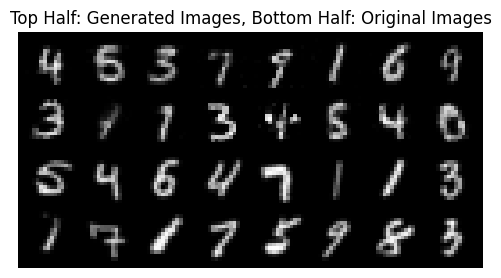

In [11]:
# Visualizing Generated and Original Images
def show_images(gen_images, real_images):
    gen_images = gen_images.view(gen_images.size(0), 1, 14, 14).cpu().data
    real_images = real_images.view(real_images.size(0), 1, 14, 14).cpu().data

    # Concatenate generated and real images
    images = torch.cat([gen_images, real_images])

    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)

    # Set smaller figure size
    plt.figure(figsize=(6, 6))  # Smaller figure
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Top Half: Generated Images, Bottom Half: Original Images')
    plt.axis('off')
    plt.show()

# Generate images
z = torch.randn(16, latent_dim).to('cuda')  # Reduced to 16 for a smaller plot
gen_imgs = generator(z)

# Get a batch of real images
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:16].view(16, -1).to('cuda')  # Reduced to 16 for a smaller plot

# Show generated vs original images
show_images(gen_imgs, real_imgs)

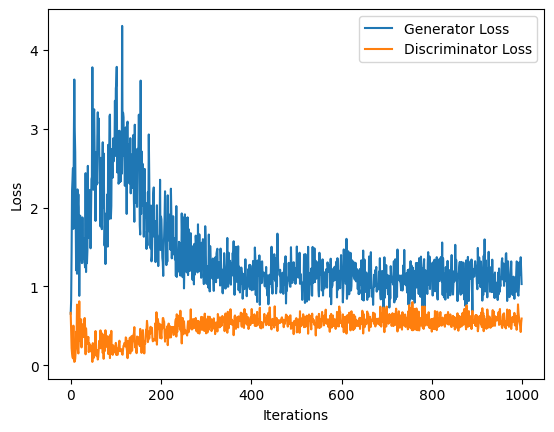

In [7]:
plt.plot(gen_losses, label='Generator Loss')
plt.plot(dis_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()